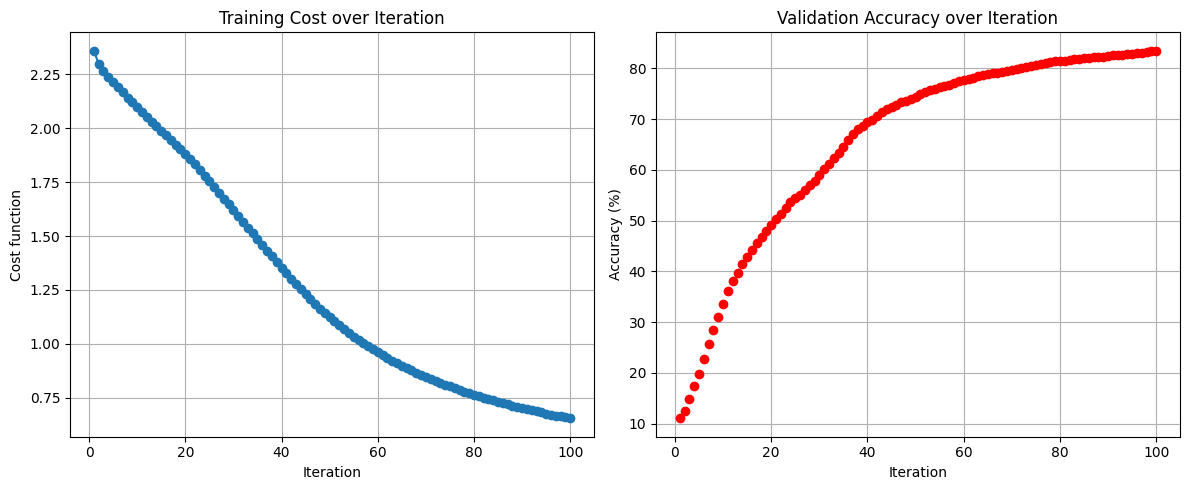

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df  = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# Separate features and labels from training set
labels      = train_df['label'].values          # shape: (m,)
pixels_data = train_df.drop('label', axis=1).values  # shape: (m, 784)

m, _ = pixels_data.shape  # number of training examples

# Normalize pixel values to [0,1] and transpose to (784, m)
X_raw = pixels_data.T / 255.0  # shape: (784, m)

# One‐hot encode labels into Y_raw of shape (10, m)
Y_raw = np.zeros((10, m))
for i, lbl in enumerate(labels):
    Y_raw[lbl, i] = 1

# Shuffle data
perm = np.random.permutation(m)
X_raw = X_raw[:, perm]
Y_raw = Y_raw[:, perm]


def ReLU(Z):
    return np.maximum(Z, 0)

def derivative_of_ReLU(Z):
    return (Z > 0).astype(float)

def softmax(Z):
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
    expZ = np.exp(Z_shifted)
    return expZ / np.sum(expZ, axis=0, keepdims=True)


def initialize_parameters():
    n_x = 784   # input dimension
    n_h = 10    # hidden units
    n_y = 10    # output classes

    # Xavier/Glorot uniform initialization
    limit1 = np.sqrt(6 / (n_x + n_h))
    W1 = np.random.uniform(-limit1, limit1, size=(n_h, n_x))
    b1 = np.zeros((n_h, 1))

    limit2 = np.sqrt(6 / (n_h + n_y))
    W2 = np.random.uniform(-limit2, limit2, size=(n_y, n_h))
    b2 = np.zeros((n_y, 1))

    return W1, b1, W2, b2


def forward_propagation(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2


def compute_cost(A2, Y):
    m = Y.shape[1]
    log_probs = np.log(A2 + 1e-8)
    cost = - np.sum(Y * log_probs) / m
    return cost


def backward_propagation(W1, b1, W2, b2, X, Y, Z1, A1, Z2, A2):
    m = X.shape[1]

    # Output layer gradients
    dZ2 = A2 - Y                                   # (n_y, m)
    dW2 = (1/m) * dZ2.dot(A1.T)                   # (n_y, n_h)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)  # (n_y, 1)

    # Hidden layer gradients
    dA1 = W2.T.dot(dZ2)                           # (n_h, m)
    dZ1 = dA1 * derivative_of_ReLU(Z1)            # (n_h, m)
    dW1 = (1/m) * dZ1.dot(X.T)                    # (n_h, n_x)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)  # (n_h, 1)

    return dW1, db1, dW2, db2

def predict(W1, b1, W2, b2, X):
    _, _, _, A2 = forward_propagation(W1, b1, W2, b2, X)
    return np.argmax(A2, axis=0)  # (m_batch,)


#split the date into to validation and training

m_total = X_raw.shape[1]
m_val = 5000

X_val = X_raw[:, :m_val]      # validation inputs
Y_val = Y_raw[:, :m_val]      # validation labels
X_train = X_raw[:, m_val:]    # training inputs
Y_train = Y_raw[:, m_val:]    # training labels


learning_rate = 0.1   # alpha
num_epochs    = 100
costs = []
val_accuracies = []
W1, b1, W2, b2 = initialize_parameters()
for epoch in range(num_epochs):
    Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, X_train)
    cost = compute_cost(A2, Y_train)
    costs.append(cost)
    dW1, db1, dW2, db2 = backward_propagation(W1, b1, W2, b2, X_train, Y_train, Z1, A1, Z2, A2)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    val_preds = predict(W1, b1, W2, b2, X_val)      # (m_val,)
    val_true  = np.argmax(Y_val, axis=0)            # (m_val,)
    val_acc   = np.mean(val_preds == val_true) * 100
    val_accuracies.append(val_acc)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), costs, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Cost function")
plt.title("Training Cost over Iteration")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, 'ro')
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy over Iteration")
plt.grid(True)

plt.tight_layout()
plt.show()

Prediction: 3
True label: 3


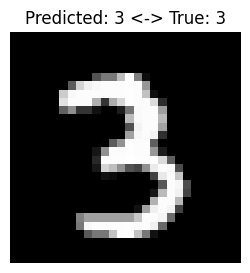

Prediction: 7
True label: 7


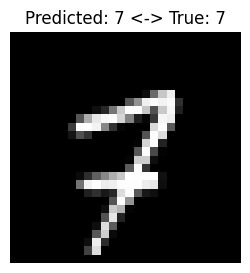

Prediction: 9
True label: 7


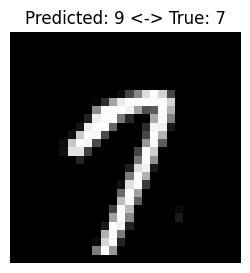

Prediction: 5
True label: 8


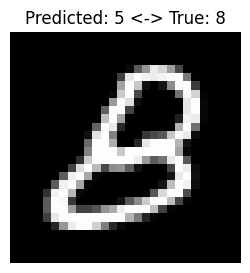

Prediction: 4
True label: 4


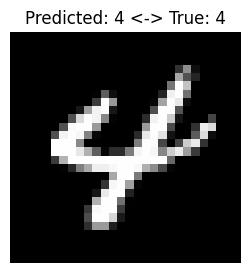

In [27]:

def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_propagation(W1, b1, W2, b2, X)
    return np.argmax(A2, axis=0)

def test_prediction(index, W1, b1, W2, b2, X_data, Y_data):
    x_col = X_data[:, index:index+1]   # shape: (784, 1)
    pred = make_predictions(x_col, W1, b1, W2, b2)[0]  # single element
    true_label = np.argmax(Y_data[:, index])
    
    print(f"Prediction: {pred}")
    print(f"True label: {true_label}")
    
    # Reshape back to 28×28 for plotting (pixels in [0,1], so multiply by 255)
    image = (x_col.reshape(28, 28) * 255).astype(np.uint8)
    plt.figure(figsize=(3,3))
    plt.axis('off')
    plt.title(f"Predicted: {pred} <-> True: {true_label}")
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.show()



for idx in np.random.choice(X_train.shape[1], size=5, replace=False):
    test_prediction(idx, W1, b1, W2, b2, X_train, Y_train)


In [22]:
X_test = test_df.values.T / 255.0
test_preds = predict(W1, b1, W2, b2, X_test)  # shape: (num_test,)
image_ids = np.arange(1, X_test.shape[1] + 1)

submission_df = pd.DataFrame({
    "ImageId": image_ids,
    "Label":   test_preds
})
submission_df.to_csv("mnist_numpy_submission.csv", index=False)
